# An EOF analysis of AO 

This notebook collects my work of Arctic Oscillation patterns and how atmospheric/surface ocean conditions correspond with different AO phases.

* Update 2016/01/08 Datasets are now coherent with Xianmin's modelling work.
* Update 2016/01/20 Speed up the code, move some calculations to `_/script/Anomaly_Calculations.py`

# Content
1. [**Import modules & tools**](#Import-modules-&-tools)
1. [**EOF modes & AO Index**](#EOF-modes-&-AO-Index)
  2. [EOF results](#EOF-results)
  2. [Get top 5% min/max](#Get-top-5%-min/max)
1. [**Anomaly combinations**](#Anomaly-combinations)
  2. [Surface atmospheric patterns](#Surface-atmospheric-patterns)
  2. [Surface ocean conditions](#Surface-ocean-conditions)

# Import modules & tools

In [1]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [2]:
import glob
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import detrend
from scipy.stats.stats import pearsonr
from NEMO_tools import reporj_NEMOgrid
from mpl_toolkits.basemap import Basemap, cm, addcyclic
% matplotlib inline

/home/yingkai/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran

In [4]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

# EOF modes & AO Index

data: CMC-GDPS (The one runs ANHA4-EXH001)
* Sea level pressure

In [7]:
year = np.arange(2002, 2015)
slp = np.empty([144, 368, 801])
for i in range(12):
    name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*slp*'+str(year[i])+'*monmean*')
    slp_obj = nc.Dataset(name[0])
    slp[i*12:(i+1)*12, :, :] = slp_obj.variables['atmpres'][:, :, :]

In [8]:
x = slp_obj.variables['LON'][:]
y = slp_obj.variables['LAT'][:]
[lon, lat] = np.meshgrid(x, y)

In [10]:
slp = Ats.seasonal_decomp3d(slp, method=0)
slp = np.transpose(slp, [1, 2, 0])
slp_np = slp[y>20, :, :]
lon_np = lon[y>20, :]
lat_np = lat[y>20, :]

In [58]:
slp_ma = np.zeros([233, 801, 144])
for i in range(233):
    for j in range(801):
        slp_ma[i, j, 12:-12] = np.convolve(slp_np[i, j, :], np.ones((24,))/24.0, mode='valid')[1:]

In [59]:
EOFs, PC, expvar = Ats.EOF(slp_ma, nmode=10, ndim=3, reverse=1)
EOFs = EOFs/100.0 # Pa to hPa
# Convert negative AO spatial pattern to positive
EOFs[:, :, 0] = -1*EOFs[:, :, 0]
PC[0, :] = -1*PC[0, :]

## EOF spatial patterns

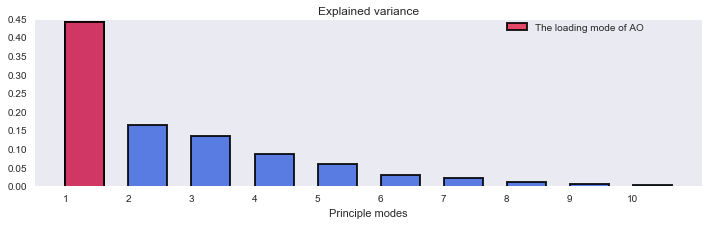

In [60]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85, color=RB)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color=AM, label='The loading mode of AO')
ax.set_xticks(np.arange(1, 11))
LG = ax.legend(numpoints=1, bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance', fontsize=12)

In [61]:
def draw_smode(lon, lat, EOFs, clevs, num, ax, edge=0):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=20, lon_0=90, round=True, ax=ax)
    proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, EOFs[:, :, num], clevs, cmap=plt.cm.RdBu_r, extend='both')
    proj.contour(x, y, EOFs[:, :, num], clevs, colors='gray', linewidths=1.5)
    if edge == 1:
        proj.contour(x, y, EOFs[:, :, num], [-0.5, 0.5], colors='k', linewidths=2.5)
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    #ax.text(0.75, 0.90, "Exp. var.: %.2f"%expvar[num], transform=ax.transAxes, \
        #fontsize=10, verticalalignment='top', bbox=props)
    return CS

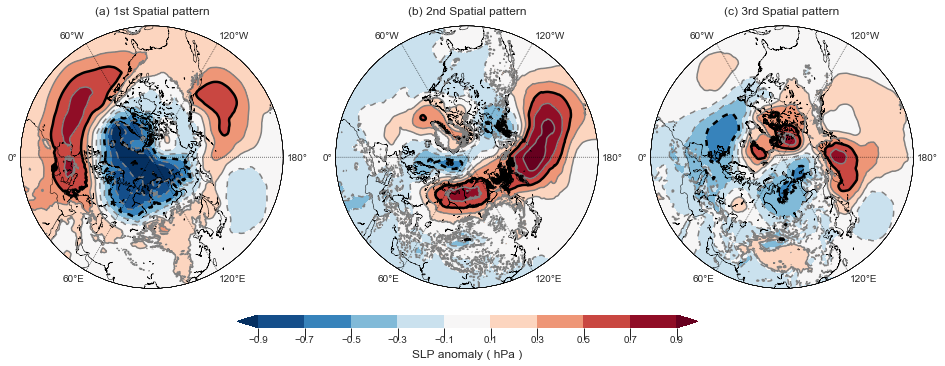

In [63]:
clevs = np.arange(-4.5, 5.5, 1)*0.2
#
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((1, 3), (0, 2), colspan=1, rowspan=1)
#ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
#
CS = draw_smode(lon_np, lat_np, EOFs, clevs, 0, ax1, edge=1)
ax1.set_title('(a) 1st Spatial pattern', y=1.025)
draw_smode(lon_np, lat_np, EOFs, clevs, 1, ax2, edge=1)
ax2.set_title('(b) 2nd Spatial pattern', y=1.025)
draw_smode(lon_np, lat_np, EOFs, clevs, 2, ax3, edge=1)
ax3.set_title('(c) 3rd Spatial pattern', y=1.025)
#draw_smode(lon_np, lat_np, EOFs, clevs, 3, ax4)
#ax4.set_title('(d) 4th Spatial pattern', y=1.025)
# bottom colorbar
cax  = fig.add_axes([0.313, 0.315, 0.4, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SLP anomaly ( hPa )', fontsize=12)
CBar.ax.tick_params(axis='x', length=12)
CBar.set_ticks(clevs)

In [21]:
save_var = {'EOFs':EOFs, 'PCs':PC, 'expvar':expvar}
scipy.io.savemat('../../_data/MAT files/SLP_EOF.mat', mdict=save_var)

In [34]:
PC_ma = np.zeros([3, 144])
for i in range(3):
    PC_ma[i, 12:-12] = np.convolve(PC[i, :], np.ones((24,))/24.0, mode='valid')[1:]
    PC_ma[PC_ma==0]=np.nan

In [26]:
#from scipy.stats.stats import pearsonr

In [15]:
#FName = '/ocean/yingkai/GEOTRACES/Simulations/SPIN06_SET02_1m_20020101_20131231_ptrc_T.nc'
#ptrc_obj = nc.Dataset(FName)
#nav_lon = ptrc_obj.variables['nav_lon'][:]
#nav_lat = ptrc_obj.variables['nav_lat'][:]

In [16]:
#bound_MAT=scipy.io.loadmat('../../_data/Exchange/Ba_boundary_ANHA4.mat')
#domain = bound_MAT['domain'].T

#corrBa = np.zeros(nav_lon.shape); corrBa[corrBa==0]=np.nan
#pBa = np.zeros(nav_lon.shape); pBa[pBa==0]=np.nan
#for i in range(800):
#    for j in range(544):
#        if domain[i, j]==1:
#            tempBa = ptrc_obj.variables['Ba'][:72, 0, i, j];
#            corrBa[i, j], pBa[i, j] = pearsonr(tempBa, PC[0, :72])

In [17]:
#MAT_Ba = scipy.io.loadmat('../../_data/Temp/Ba.mat')
#Ba = MAT_Ba['Ba_anom'][:]
#Balon = MAT_Ba['Balon'][:]
#Balat = MAT_Ba['Balat'][:]

In [18]:
#test=144
#corrBa = np.zeros(Balon.shape); corrBa[corrBa==0]=np.nan
#pBa = np.zeros(Balon.shape); pBa[pBa==0]=np.nan
#for i in range(15):
#    for j in range(180):
#        tempBa = Ba[:test, i, j];
#        corrBa[i, j], pBa[i, j] = pearsonr(tempBa, PC[0, :test])

In [19]:
#lev = np.array([-0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45])
#fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
#proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
#proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
#proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
#proj.drawcoastlines(linewidth=1.5, color='k')
#
#x, y=proj(Balon, Balat)
#CS=proj.contourf(x, y, corrBa, lev, cmap=plt.cm.RdBu_r, extend='both')
#proj.contour(x, y, pBa, [0.05], colors=('k',), linewidths=1.5)
#cax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
#CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
#CBar.set_label('Pearson correlation index', fontsize=12)
#CBar.ax.tick_params(axis='x', length=22)
#CBar.set_ticks(lev)
#
#ax.set_title('An example of "emps" @ Jan 2002')

In [24]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]

nav_lon = coordinate_obj.variables['nav_lon'][:]
nav_lat = coordinate_obj.variables['nav_lat'][:]

In [25]:
FWC_name = sorted(glob.glob('../../_data/MAT files/FWC/FWC_ANHA4_*.mat'))
FWC = np.zeros([144, 800, 544])

for i in range(144):
    MAT = scipy.io.loadmat(FWC_name[i])
    FWC[i, :, :] = MAT['FWC'][:]
FWC[np.isnan(FWC)] = 0

In [27]:
# ocean u/v
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current.mat')
vozocrtx0 = MAT['vozocrtx0'][:]
vozocrtx1 = MAT['vozocrtx1'][:]
vomecrty0 = MAT['vomecrty0'][:]
vomecrty1 = MAT['vomecrty1'][:]

# BG SSH
H_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc'
h_obj = nc.Dataset(H_FName)
SSH = h_obj.variables['sossheig'][:, :, :]
# Sea-surface salinity
S_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isssalin_monmean.nc'
S_obj = nc.Dataset(S_FName)
S = S_obj.variables['isssalin'][:, :, :]
# SST
T_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isstempe_monmean.nc'
T_obj = nc.Dataset(T_FName)
T = T_obj.variables['isstempe'][:, :, :]

# SSH
obj_h = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc')
ssh = obj_h.variables['sossheig'][:]
ssh[ssh>100] = np.nan
# Tracer modeling output
MAT = scipy.io.loadmat('../../_data/MAT files/BASE03_65m_tracer_vals.mat')
Ba = MAT['Ba'][:]
d18O = MAT['d18O'][:]
# GDPS-SLP
year = np.arange(2002, 2014)
slp = np.empty([144, 368, 801])
for i in range(12):
    name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*slp*'+str(year[i])+'*monmean*')
    slp_obj = nc.Dataset(name[0])
    slp[i*12:(i+1)*12, :, :] = slp_obj.variables['atmpres'][:, :, :]
x = slp_obj.variables['LON'][:]
y = slp_obj.variables['LAT'][:]
[slp_lon, slp_lat] = np.meshgrid(x, y)

slp = slp[:, y>20, :]/100.0
slp_lon = slp_lon[y>20, :]
slp_lat = slp_lat[y>20, :]


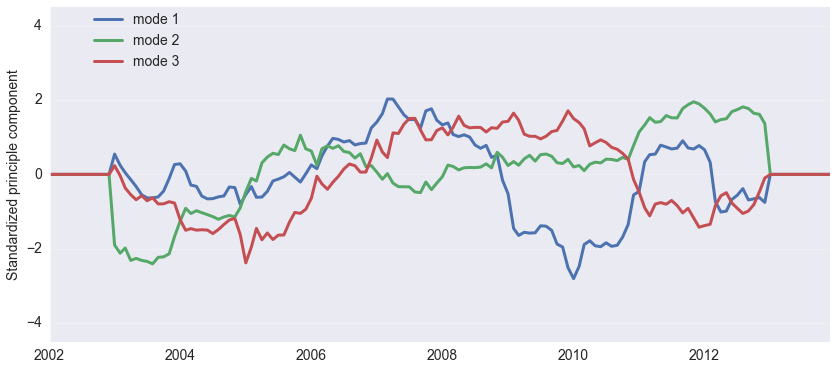

In [65]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca()
ax.grid(linestyle=':')
ax.yaxis.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False) 
ax.spines["right"].set_visible(False)
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylim([-4.5, 4.5])
ax.set_ylabel('Standardized principle component', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
            labelbottom="on", left="off", right="off", labelleft="on")

ax = fig.gca(); ax.grid()
ax.plot(date_list, PC[0, :], '-',  lw=3, label='mode 1')
ax.plot(date_list, PC[1, :], '-', lw=3, label='mode 2')
ax.plot(date_list, PC[2, :], '-',  lw=3, label='mode 3')
#ax.plot(date_list, PC[3, :], '-', lw=3, label='mode 4')

LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)

In [66]:
lev_dT = np.array([-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11])
lev_slp = np.array([-3.85, -3.15, -2.45, -1.75, -1.05, -0.35, 0.35, 1.05, 1.75, 2.45, 3.15, 3.85])
lev_corr = np.array([-0.45, -0.35, -0.25, -0.15, -0.1, 0.1, 0.15, 0.25, 0.35, 0.45])

In [37]:
def draw_SSH_UV():
    n=4
    fig=plt.figure(figsize=(16, 16));

    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
        
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    
    CS = proj.contourf(x, y, dssh*100, lev_dT, cmap = plt.cm.RdBu_r, extend='both')

    cax  = fig.add_axes([0.175, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('SSH  ( 0.01m )', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT)
    
    ax1.set_title('(a) SSH', fontsize=14)
    
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax2)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    Q = proj.quiver(x[::n, ::n], y[::n, ::n], u[::n, ::n], v[::n, ::n], 
    width=0.002, headwidth=3, scale=1.75, color='0.25')
    qk = plt.quiverkey(Q, 0.2, 0.15, 0.1, r'$0.1\ m\cdot s^{-1}$', coordinates='figure', fontproperties={'weight': 'bold'})
    
    ax2.set_title('(b) Ocean flow', fontsize=14)

In [50]:
def draw_FWC_SST():
    fig=plt.figure(figsize=(16, 16));

    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
    
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    CS = proj.contourf(x, y, dFWC, lev_dT/4.0, cmap = plt.cm.PiYG, extend='both', )   
    
    cax  = fig.add_axes([0.125, 0.3, 0.35, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Freshwater content (dep < 65m)  ( m )', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT/4.0)
    
    ax1.set_title('(a) Freshwater content', fontsize=14)


In [39]:
def draw_Ba_d18O():
    fig=plt.figure(figsize=(16, 16));

    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    CS = proj.contourf(x, y, dBa, lev_dT, cmap = plt.cm.BrBG, extend='both')
    
    cax  = fig.add_axes([0.175, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Dissolved Barium (nm)', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT)

    ax1.set_title('(b.1) Dissolved Ba', fontsize=14)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax2)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    CS = proj.contourf(x, y, dd18O, lev_dT/5.0, cmap = plt.cm.RdBu_r, extend='both')
    
    cax  = fig.add_axes([0.6, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('d18O', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT/5.0)

    ax2.set_title('(b.2) d18O', fontsize=14)

In [40]:
def draw_500_1000_corr():
    fig=plt.figure(figsize=(16, 16));

    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=10, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None, zorder=0)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(hgt_lon, hgt_lat)
    CS = proj.contourf(x, y, corr1000, lev_corr, cmap = plt.cm.RdBu_r, extend='both')
    proj.contourf(x, y, p1000, [0, 0.05], hatches=['...', ' '], colors='none', zorder=4)
    proj.contour(x, y, corr1000, [-0.1, 0.1], linewidths=2.5, colors=('gray',), zorder=4)
    
    cax  = fig.add_axes([0.175, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Correlation ind.', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_corr)

    #ax1.set_title('(c.1) PC .v.s. 1000hPa GPH', fontsize=14)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=10, lon_0=0, round=True, ax=ax2)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    #proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(hgt_lon, hgt_lat)
    CS = proj.contourf(x, y, corr500, lev_corr, cmap = plt.cm.RdBu_r, extend='both')
    proj.contourf(x, y, p500, [0, 0.05], hatches=['...', ' '], colors='none', zorder=4)
    proj.contour(x, y, corr500, [-0.1, 0.1], linewidths=2.5, colors=('gray',), zorder=4)
    
    cax  = fig.add_axes([0.6, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Correlation ind.', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_corr)

    #ax2.set_title('(c.2) PC v.s. 500hPa GPH', fontsize=14)
    return ax1, ax2

In [41]:
def draw_slp():
    fig = plt.figure(figsize=(8, 8));
    ax1 = fig.gca()
    #ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    #ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=40, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    #proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(slp_lon, slp_lat)
    CS = proj.contourf(x, y, dslp, lev_slp, cmap = plt.cm.RdBu_r, extend='both')
    
    cax  = fig.add_axes([0.1375, 0.05, 0.75, 0.035])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('SLP (hPa)', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_slp)

    ax1.set_title('SLP', fontsize=14)

    #proj=Basemap(projection='npstere', resolution='l', boundinglat=40, lon_0=0, round=True, ax=ax2)
    #proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    ##proj.fillcontinents(color='0.8', lake_color=None)
    #proj.drawcoastlines(linewidth=0.5, color='k')
    #x, y = proj(hgt_lon, hgt_lat)
    #CS = proj.contourf(x, y, dhgt500, lev_hgt*2, cmap = plt.cm.RdBu_r, extend='both')
    #
    #cax  = fig.add_axes([0.6, 0.3, 0.25, 0.02])
    #CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    #CBar.set_label('GPH', fontsize=12)
    #CBar.ax.tick_params(axis='x', length=0, direction='in')
    #CBar.set_ticks(lev_hgt*2)
    #
    #ax2.set_title('(c.2) 500hPa GPH', fontsize=14)

In [55]:
def Get_compsit_a(t, thres=0):
    thres = 0
    u_p    = np.nanmean(vozocrtx0[t>thres, :, :], 0)
    v_p    = np.nanmean(vomecrty0[t>thres, :, :], 0)
    Ba_p   = np.nanmean(Ba  [t>thres, :, :], 0)
    d18O_p = np.nanmean(d18O[t>thres, :, :], 0)
    FWC_p  = np.nanmean(FWC [t>thres, :, :], 0) 
    S_p    = np.nanmean(S   [t>thres, :, :], 0)
    T_p    = np.nanmean(T   [t>thres, :, :], 0)
    ssh_p  = np.nanmean(ssh [t>thres, :, :], 0)
    slp_p  = np.nanmean(slp [t>thres, :, :], 0)
    #hgt1000_p = np.nanmean(hgt[t>thres, 0, :, :], 0)
    #air1000_p = np.nanmean(at [t>thres, 0, :, :], 0)
    #hgt500_p  = np.nanmean(hgt[t>thres, 5, :, :], 0)

    u_n    = np.nanmean(vozocrtx0[t<-thres, :, :], 0)
    v_n    = np.nanmean(vomecrty0[t<-thres, :, :], 0)
    Ba_n   = np.nanmean(Ba  [t<-thres, :, :], 0)
    d18O_n = np.nanmean(d18O[t<-thres, :, :], 0)
    FWC_n  = np.nanmean(FWC [t<-thres, :, :], 0)
    T_n    = np.nanmean(T   [t<-thres, :, :], 0)
    ssh_n  = np.nanmean(ssh [t<-thres, :, :], 0)
    slp_n  = np.nanmean(slp [t<-thres, :, :], 0) 
    #hgt1000_n = np.nanmean(hgt[t<-thres, 0, :, :], 0)
    #air1000_n = np.nanmean(at [t<-thres, 0, :, :], 0)
    #hgt500_n  = np.nanmean(hgt[t<-thres, 5, :, :], 0)
    #corr500 = np.zeros([73, 145])
    #corr1000 = np.zeros([73, 145])
    #p500 = np.zeros([73, 145])
    #p1000 = np.zeros([73, 145])
    #for i in range(73):
    #    for j in range(145):
    #        PC_temp = PC_with_scale[num, 5:]
    #        hgt1000_temp = hgt[:-5, 0, i, j]
    #        hgt500_temp = hgt[:-5, 5, i, j]
    #        corr1000[i, j], p1000[i, j] = pearsonr(PC_temp, hgt1000_temp)
    #        corr500[i, j], p500[i, j] = pearsonr(PC_temp, hgt500_temp)
    u = u_p - u_n; v = v_p - v_n; dslp = slp_p - slp_n; dT = T_p - T_n; #dair = air1000_p - air1000_n
    dFWC = FWC_p - FWC_n; dBa = Ba_p - Ba_n; dd18O = d18O_p - d18O_n; dssh = ssh_p - ssh_n
    #dhgt1000 = hgt1000_p - hgt1000_n; dhgt500 = hgt500_p - hgt500_n
    return u, v, dFWC, dBa, dd18O, dssh, dslp, #dair, #dhgt1000, dhgt500, S_p#, corr1000, p1000, corr500, p500

0
1
2


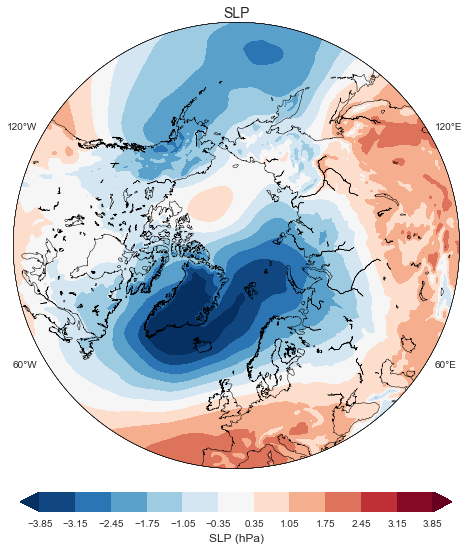

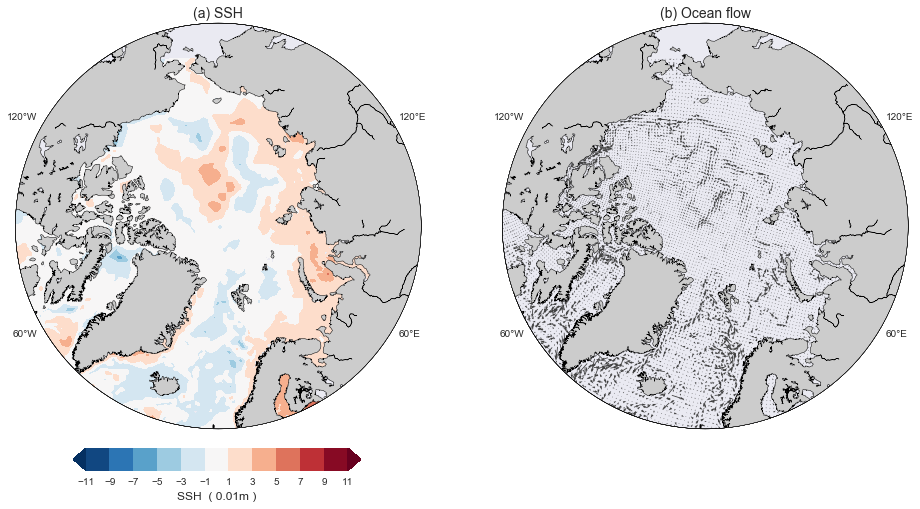

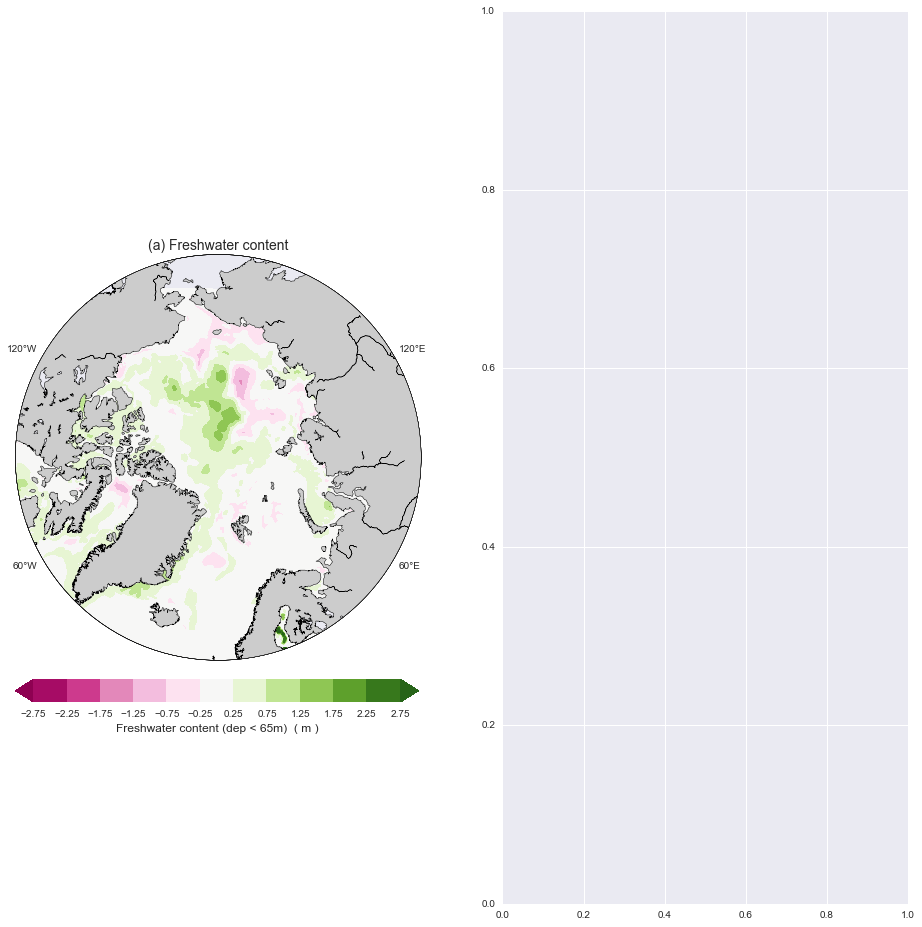

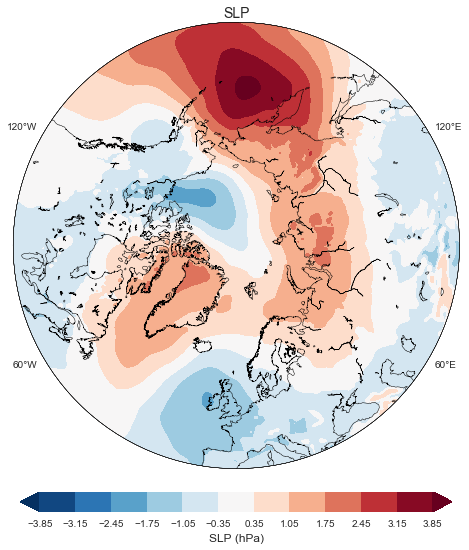

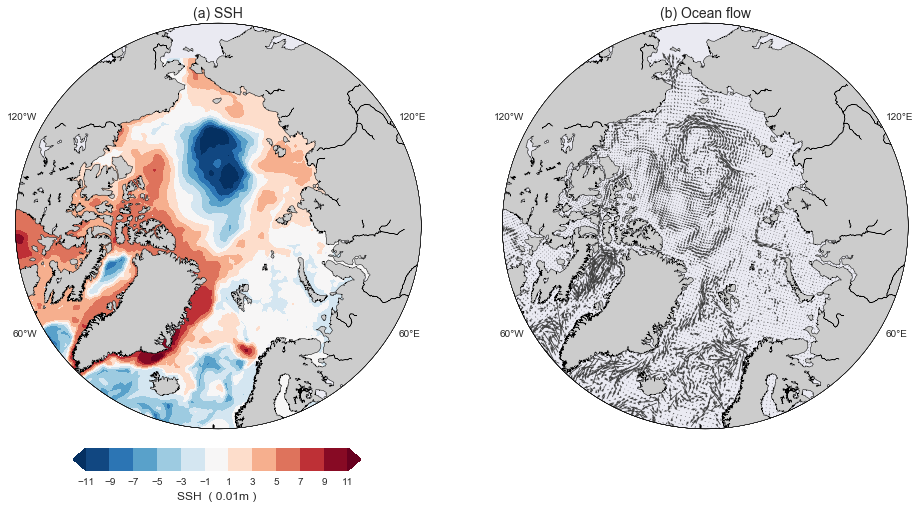

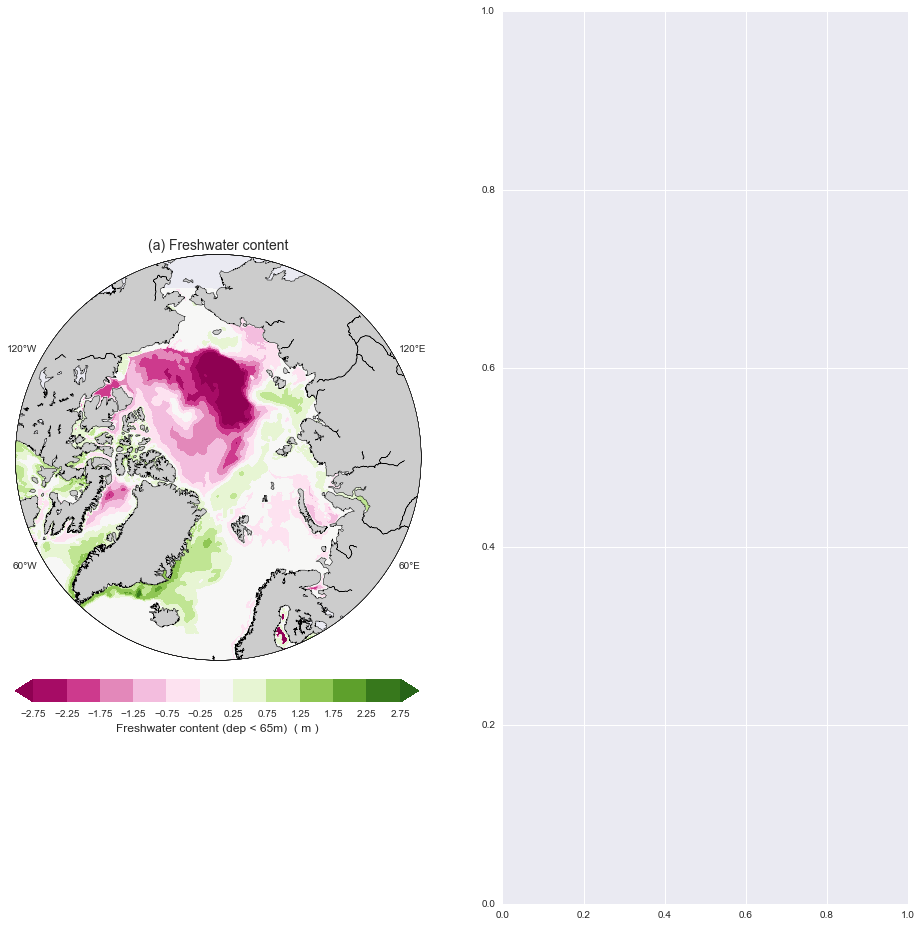

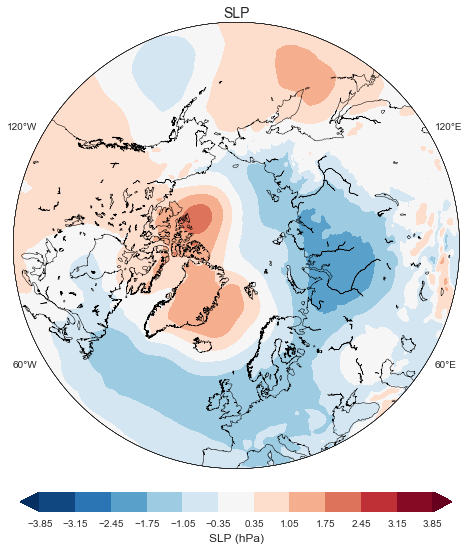

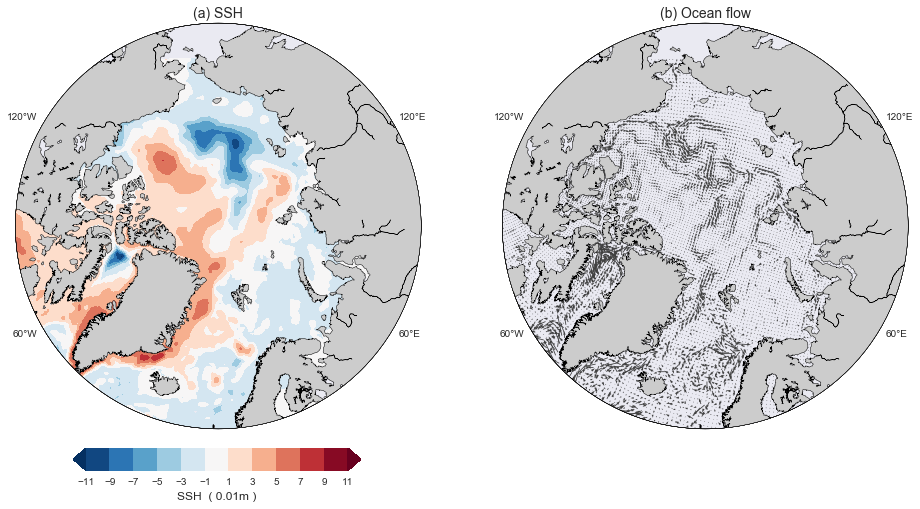

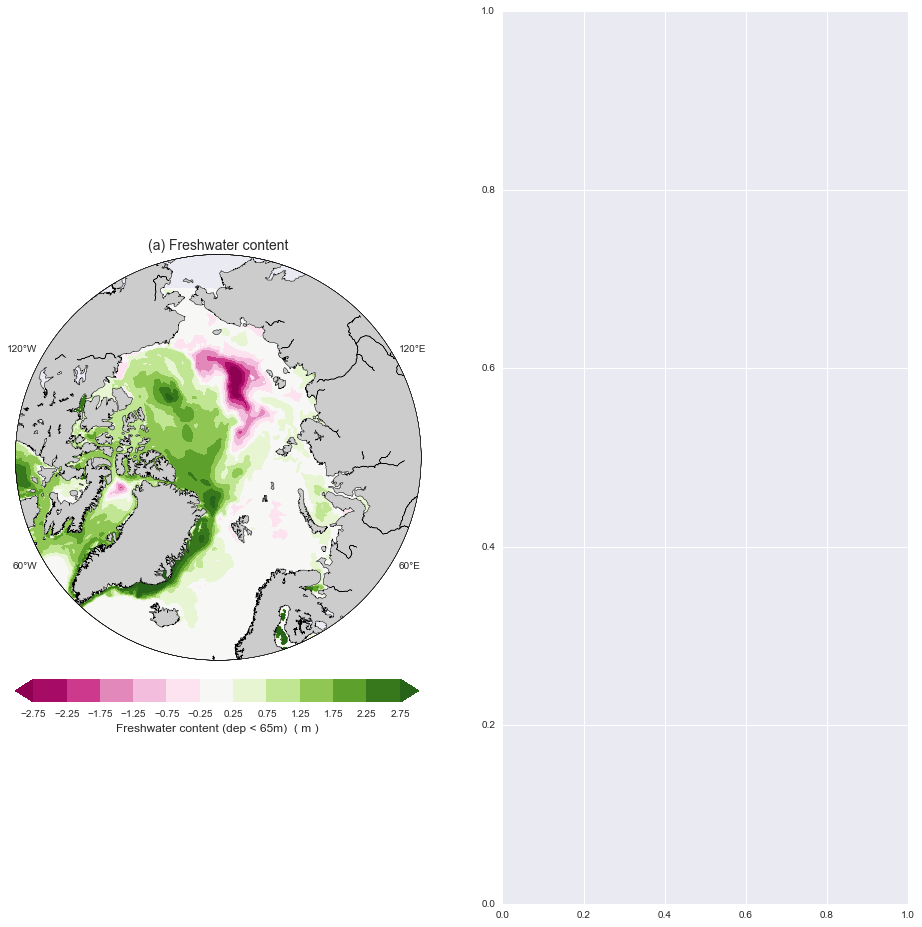

In [67]:
for i in range(3):
    print(i)
    u, v, dFWC, dBa, dd18O, dssh, dslp = Get_compsit_a(PC[i, :])
    draw_slp()
    draw_SSH_UV()
    draw_FWC_SST()